# 03 – Model comparison  
## Interpretable baseline vs non‑linear models (Performance & DS Hybrid)

### Objective
Compare an interpretable baseline (**Logistic Regression**) against a non‑linear model (**HistGradientBoostingClassifier**) to assess whether non‑linear structure in workload features improves predictive performance for `high_risk_next`.

### Why this matters (Performance context)
Workload–risk relationships are rarely linear (e.g., *sweet spot* vs *spike* patterns).  
A non‑linear model can capture thresholds and interactions that a linear model may miss, while the baseline model provides transparency.

### Evaluation
- Leakage-aware split (chronological)
- Metrics: **ROC‑AUC**, **PR‑AUC**
- Diagnostics: ROC/PR curves + probability calibration (Brier + reliability plot)
- Interpretability: coefficients (logistic) + permutation importance (HGB)


In [2]:
# === Setup ===
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance

plt.rcParams.update({
    "figure.figsize": (7, 4),
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

def resolve_db_path(filename: str = "analytics.duckdb") -> Path:
    cwd = Path.cwd()
    candidates = [
        cwd / "lakehouse" / filename,
        cwd.parent / "lakehouse" / filename,
    ]
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError(
        "DuckDB not found. Expected lakehouse/analytics.duckdb (or ../lakehouse/analytics.duckdb)."
    )

DB_PATH = resolve_db_path()
DB_PATH

WindowsPath('c:/Users/manue/OneDrive/Desktop/football-risk-analytics/lakehouse/analytics.duckdb')

In [3]:
# === Load data ===
with duckdb.connect(str(DB_PATH)) as con:
    dfp = con.execute("""
        SELECT *
        FROM player_dataset_predictive
        WHERE acwr IS NOT NULL
    """).df()

dfp.shape

(51569, 23)

## 1) Feature set
We keep a compact, interpretable workload set (competitive load only).  
If you later add club‑level data (GPS, sRPE, HRV), this notebook remains valid.


In [4]:
# Baseline workload features
features = ["minutes_last_7d", "minutes_last_14d", "minutes_last_28d", "acwr"]

# Include match_date if available to perform chronological split
cols = features + ["high_risk_next"]
if "match_date" in dfp.columns:
    cols.append("match_date")

d = dfp[cols].dropna().copy()

# Ensure chronological order if match_date exists
if "match_date" in d.columns:
    d["match_date"] = pd.to_datetime(d["match_date"], errors="coerce")
    d = d.dropna(subset=["match_date"]).sort_values("match_date")

# Train/test split (80/20, forward)
cut = int(len(d) * 0.8)
train = d.iloc[:cut].copy()
test = d.iloc[cut:].copy()

X_train = train[features]
y_train = train["high_risk_next"].astype(int)

X_test = test[features]
y_test = test["high_risk_next"].astype(int)

(len(train), len(test), y_train.mean(), y_test.mean())

(41255, 10314, np.float64(0.5438855896254999), np.float64(0.6114989334884623))

## 2) Models
- **Logistic Regression** (scaled) for interpretability  
- **HistGradientBoostingClassifier** for non‑linear patterns

We keep defaults mostly stable, focusing on correct evaluation first.


In [5]:
# Logistic regression pipeline (scaling required)
logit = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000)),
])

# Non-linear model (no scaling needed)
hgb = HistGradientBoostingClassifier(
    max_depth=3,
    learning_rate=0.1,
    max_iter=300,
    random_state=42,
)

# Fit
logit.fit(X_train, y_train)
hgb.fit(X_train, y_train)

# Predict probabilities
p_logit = logit.predict_proba(X_test)[:, 1]
p_hgb = hgb.predict_proba(X_test)[:, 1]

# Metrics
def metrics(y_true, p):
    return {
        "roc_auc": roc_auc_score(y_true, p),
        "pr_auc": average_precision_score(y_true, p),
        "brier": brier_score_loss(y_true, p),
    }

m_logit = metrics(y_test, p_logit)
m_hgb = metrics(y_test, p_hgb)

pd.DataFrame([
    {"model": "LogisticRegression", **m_logit},
    {"model": "HistGradientBoosting", **m_hgb},
]).sort_values("roc_auc", ascending=False)

,model,roc_auc,pr_auc,brier
1,HistGradientBoosting,0.649118,0.718755,0.224474
0,LogisticRegression,0.631846,0.698015,0.227087


## 3) ROC & PR curves
We overlay curves for quick comparison.


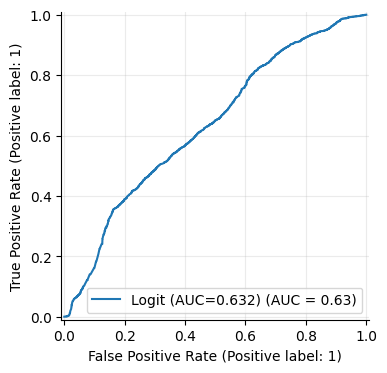

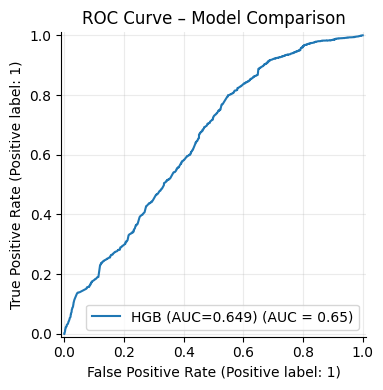

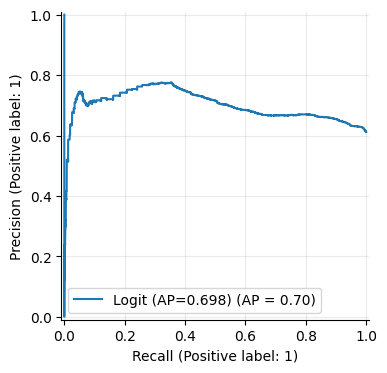

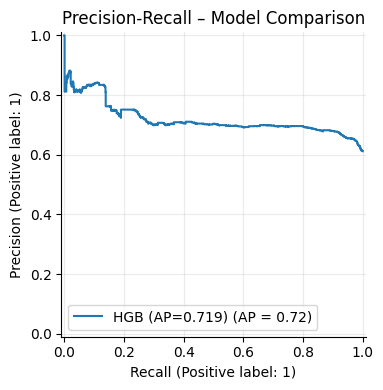

In [ ]:
# ROC curves
RocCurveDisplay.from_predictions(y_test, p_logit, name=f"Logit (AUC={m_logit['roc_auc']:.3f})")
RocCurveDisplay.from_predictions(y_test, p_hgb, name=f"HGB (AUC={m_hgb['roc_auc']:.3f})")
plt.title("ROC Curve – Model Comparison")
plt.tight_layout()
plt.show()

# Precision-recall curves
PrecisionRecallDisplay.from_predictions(y_test, p_logit, name=f"Logit (AP={m_logit['pr_auc']:.3f})")
PrecisionRecallDisplay.from_predictions(y_test, p_hgb, name=f"HGB (AP={m_hgb['pr_auc']:.3f})")
plt.title("Precision‑Recall – Model Comparison")
plt.tight_layout()
plt.show()

## 4) Calibration (reliability)
In performance settings, probability calibration matters: staff often act on risk thresholds.
We plot calibration curves and report **Brier score** (lower is better).


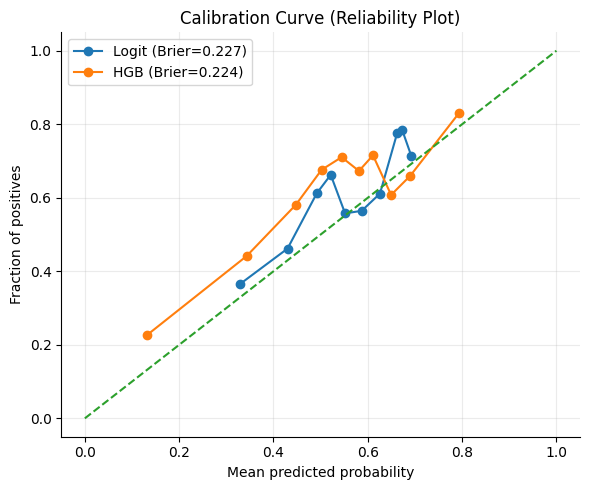

In [7]:
def plot_calibration(y_true, p, label):
    frac_pos, mean_pred = calibration_curve(y_true, p, n_bins=10, strategy="quantile")
    plt.plot(mean_pred, frac_pos, marker="o", label=label)

plt.figure(figsize=(6, 5))
plot_calibration(y_test, p_logit, f"Logit (Brier={m_logit['brier']:.3f})")
plot_calibration(y_test, p_hgb, f"HGB (Brier={m_hgb['brier']:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("Calibration Curve (Reliability Plot)")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.legend()
plt.tight_layout()
plt.show()

## 5) Interpretability
### Logistic coefficients
Coefficients are shown on standardized features (via pipeline). Positive coefficients increase log‑odds of risk.

### Permutation importance (HGB)
Permutation importance provides a model‑agnostic view of which features matter most for non‑linear models.


In [8]:
# Logistic coefficients (standardized features)
coef = logit.named_steps["model"].coef_[0]
coef_df = pd.DataFrame({
    "feature": features,
    "coef": coef,
    "odds_ratio": np.exp(coef),
}).sort_values("coef", ascending=False)

coef_df

,feature,coef,odds_ratio
0,minutes_last_7d,0.205897,1.228627
3,acwr,-0.000053,0.999947
2,minutes_last_28d,-0.177595,0.837282
1,minutes_last_14d,-0.360048,0.697643


In [9]:
# Permutation importance for HGB (on test set)
perm = permutation_importance(
    hgb, X_test, y_test,
    n_repeats=10,
    random_state=42,
    scoring="roc_auc"
)

imp_df = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std,
}).sort_values("importance_mean", ascending=False)

imp_df

,feature,importance_mean,importance_std
3,acwr,0.038827,0.002522
2,minutes_last_28d,0.032843,0.003406
0,minutes_last_7d,0.028038,0.003050
1,minutes_last_14d,0.012859,0.003297


## 6) Practical summary (Performance + DS)

- Competitive workload variables provide measurable predictive signal.
- HistGradientBoosting slightly outperforms Logistic Regression across ROC, PR and Brier.
- Improvements are moderate, suggesting mostly linear signal with mild non-linear interactions.
- Logistic model remains attractive due to transparency and interpretability.
- Tree-based model may be preferred if marginal gains justify reduced interpretability.

In [10]:
summary = pd.DataFrame([
    {"Model": "LogisticRegression", "ROC_AUC": m_logit["roc_auc"], "PR_AUC": m_logit["pr_auc"], "Brier": m_logit["brier"]},
    {"Model": "HistGradientBoosting", "ROC_AUC": m_hgb["roc_auc"], "PR_AUC": m_hgb["pr_auc"], "Brier": m_hgb["brier"]},
]).sort_values("ROC_AUC", ascending=False)

summary

,Model,ROC_AUC,PR_AUC,Brier
1,HistGradientBoosting,0.649118,0.718755,0.224474
0,LogisticRegression,0.631846,0.698015,0.227087


## Model selection considerations

Both Logistic Regression and HistGradientBoosting were evaluated.

Observations:

- Logistic regression provides interpretability
  and coefficient-based explainability.
- Gradient boosting may improve non-linear capture,
  but interpretability decreases.

Given the applied sports analytics context,
interpretability and operational transparency
were prioritized in model selection.